In [1]:
import os

credentials = {"username":"lucasburns",
               "key":"#####################"}
os.environ['KAGGLE_USERNAME']=credentials['username']
os.environ['KAGGLE_KEY']=credentials['key']
!kaggle datasets download -d moltean/fruits
!unzip fruits.zip

Streaming output truncated to the last 5000 lines.
  inflating: fruits-360/Training/Tomato 3/111_100.jpg  
  inflating: fruits-360/Training/Tomato 3/112_100.jpg  
  inflating: fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: fruits-360/Training/Tomato 3/123_100.jpg  
  inflating: fruits-360/Training/Tomato 3/124_100.jpg  
  inflating: fruits-360/Training/Tomato 3/125_100.jpg  
  inflating: fruits-360/Training/Tomato 3/126_100.jpg  
  inflating: fruits-360/Training/Tomato 3/127_100.jpg  
  inflating: fruits-360/Training/Tomato 3/128_100.jpg

In [2]:
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F 
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from torchsummary import summary
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable

import os, time, copy
from glob import glob
from tqdm.notebook import tqdm

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
plt.style.use(['dark_background'])
plt.rcParams['figure.dpi'] = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
writer = SummaryWriter()

PATH = 'fruits-360/'

In [3]:
os.rename(PATH + 'Training', PATH + 'train')
os.rename(PATH + 'Test', PATH + 'test')

print('Number of classes:', len(os.listdir(PATH + 'train/')))
print('Number of training images:', len(glob(os.path.join(PATH, 'train', '*/*.jpg'))))
print('Number of testing images:', len(glob(os.path.join(PATH, 'test', '*/*.jpg'))))

Number of classes: 131
Number of training images: 67692
Number of testing images: 22688


## Creating a Dataframe

In [4]:
CLASSES = ['train', 'test']
BATCH_SIZE = 32

img_transforms = transforms.Compose([
    transforms.ToTensor()])

img_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x), img_transforms)
                                        for x in CLASSES}

dataloaders = {x: DataLoader(img_datasets[x], batch_size=BATCH_SIZE, shuffle=True)
                                        for x in CLASSES}

ds_size = {x: len(img_datasets[x]) for x in CLASSES}
class_names = img_datasets['train'].classes

In [5]:
samples = img_datasets['train'].samples

filepaths = list(zip(*samples))[0]
le_name = list(zip(*samples))[1]
idx_class = {b: a for a, b in img_datasets['train'].class_to_idx.items()}

df = pd.DataFrame(filepaths, columns=['filepath'])
df = pd.concat([df, pd.Series(le_name)], axis=1).rename(columns={0: 'le_name'})
df['class'] = df['le_name'].map(idx_class)

df.head()

filepath  le_name           class
0    fruits-360/train/Apple Braeburn/0_100.jpg        0  Apple Braeburn
1  fruits-360/train/Apple Braeburn/100_100.jpg        0  Apple Braeburn
2  fruits-360/train/Apple Braeburn/101_100.jpg        0  Apple Braeburn
3  fruits-360/train/Apple Braeburn/102_100.jpg        0  Apple Braeburn
4  fruits-360/train/Apple Braeburn/103_100.jpg        0  Apple Braeburn

In [6]:
print(df['class'].value_counts().head(10))
print(26 * '-')
print('Max number of images in a class: {}'.format(list(df['class'].value_counts().items())[0]))
print('Min number of images in a class: {}'.format(list(df['class'].value_counts(ascending=True).items())[0]))
print('The average number of images in a class: {:.0f}'.format(df['class'].value_counts().mean()))

Grape Blue            984
Plum 3                900
Tomato 3              738
Peach 2               738
Strawberry Wedge      738
Cherry 2              738
Tomato 1              738
Melon Piel de Sapo    738
Cherry Rainier        738
Walnut                735
Name: class, dtype: int64
--------------------------
Max number of images in a class: ('Grape Blue', 984)
Min number of images in a class: ('Ginger Root', 297)
The average number of images in a class: 517


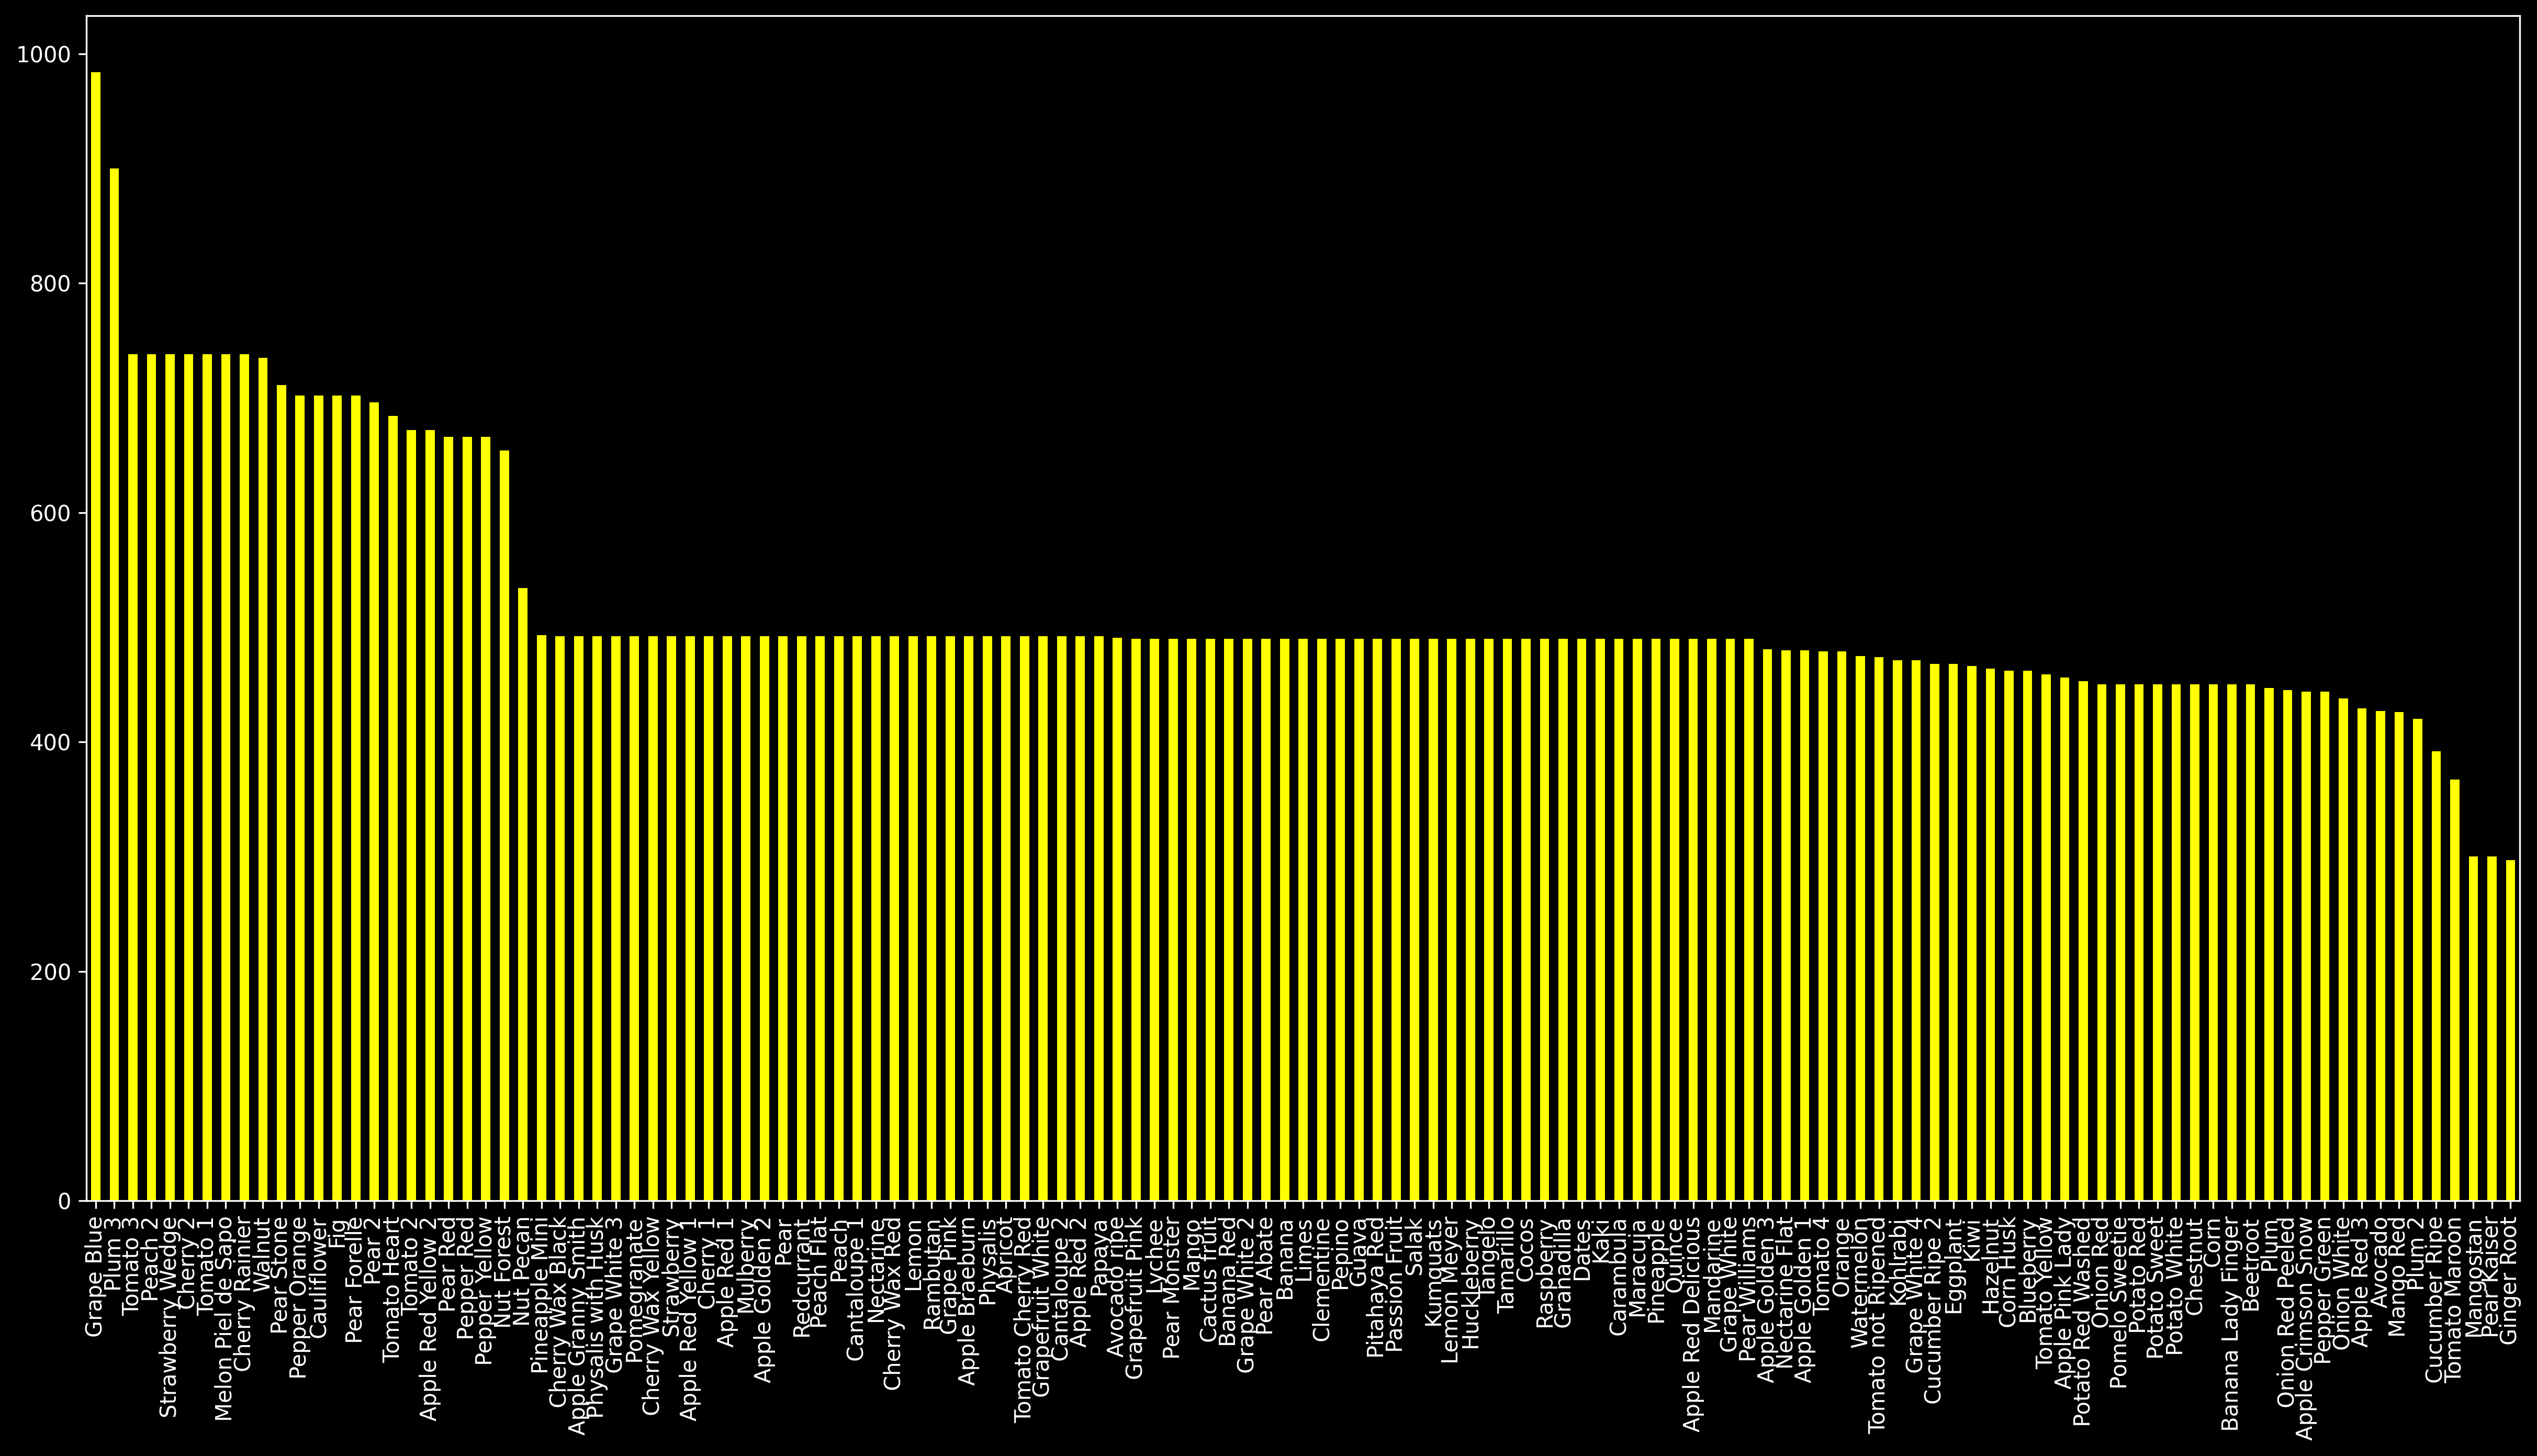

In [7]:
df['class'].value_counts().plot.bar(figsize=(20, 10), color='yellow');

## Information for normalization

In [8]:
mean = 0.
std = 0.

for images, _ in dataloaders['train']:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= ds_size['train']
std /= ds_size['train']

print(mean)
print(std)

tensor([0.6840, 0.5786, 0.5037])
tensor([0.2586, 0.3219, 0.3662])


## Transformations

In [9]:
BATCH_SIZE = 32
NUM_EPOCHS = 20
LR = 0.01
NUM_CLASSES = len(class_names)

mean = [0.6840, 0.5786, 0.5037]
std = [0.2586, 0.3219, 0.3662]

img_transforms = {
    'train': transforms.Compose([
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)]), 

    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)]),

    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)])
}

img_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x), img_transforms[x])
                                        for x in CLASSES}

ds_size = {x: len(img_datasets[x]) for x in CLASSES}
class_names = img_datasets['train'].classes

indices = list(range(len(img_datasets['train'])))
np.random.shuffle(indices)

train_indices, val_indices = np.split(indices, [int(0.8*ds_size['train'])])

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(img_datasets['train'], batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(img_datasets['train'], batch_size=BATCH_SIZE, sampler=valid_sampler)

base_dataloaders = {x: DataLoader(img_datasets[x], batch_size=BATCH_SIZE, shuffle=True)
                                        for x in CLASSES}

dataloaders = {'train': train_loader, 'valid': val_loader, 'test': base_dataloaders['test']}
datalens = {'train': len(train_indices), 'valid': len(val_indices), 'test': len(img_datasets['test'])}

In [10]:
datalens['train'] + datalens['valid'] == ds_size['train']

True

## Viewing a batch of images

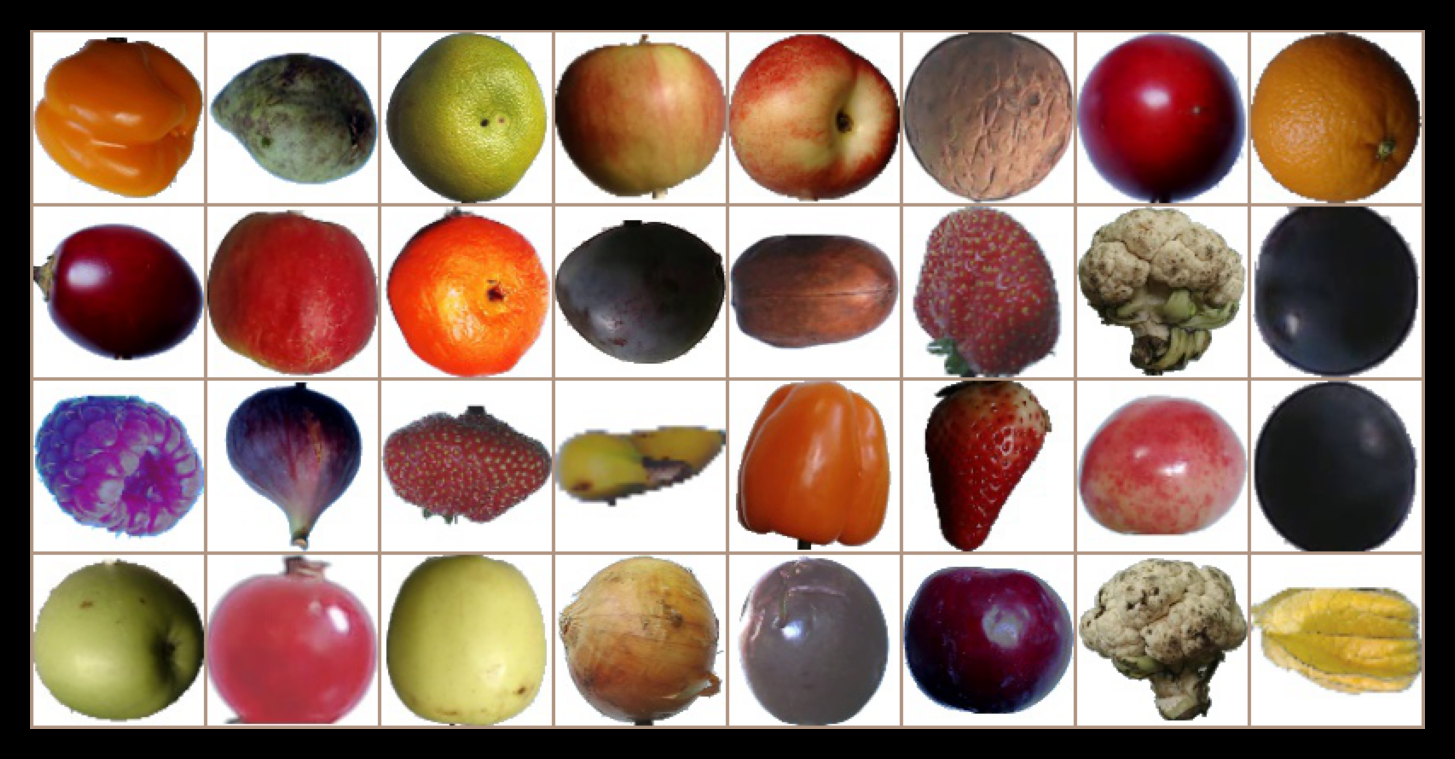

In [11]:
imgs, classes = next(iter(dataloaders['train']))

outputs = make_grid(imgs)

outputs = outputs.permute(1, 2, 0)
outputs = outputs * torch.tensor(std) + torch.tensor(mean)
outputs = torch.clamp(outputs, 0, 1)
plt.imshow(outputs)
plt.axis('off');

In [12]:
def accuracy(output, label):
    _, pred = torch.max(output, dim=1)
    return ((pred == label).sum().item() / len(pred)) * 100

def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Define the Model

In [13]:
class SecondModel(nn.Module):
    def __init__(self):
        super(SecondModel, self).__init__()
        self.pad = nn.ZeroPad2d((0, 1, 1, 0))
        self.conv1 = nn.Conv2d(3, 16, 2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 2)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 2)
        self.bn4 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128*6*6, 150)
        self.fc2 = nn.Linear(150, NUM_CLASSES)

    def forward(self, x):
         x = self.pool(F.relu(self.bn1(self.conv1(self.pad(x)))))
         x = self.pool(F.relu(self.bn2(self.conv2(self.pad(x)))))
         x = self.pool(F.relu(self.bn3(self.conv3(self.pad(x)))))
         x = self.pool(F.relu(self.bn4(self.conv4(self.pad(x)))))
         x = x.view(-1, 128*6*6)
         x = F.dropout(F.relu(self.fc1(x)), training=self.training, p=0.4)
         x = self.fc2(x)

         return x

model = SecondModel().to(device)
summary(model, (3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 101, 101]               0
            Conv2d-2         [-1, 16, 100, 100]             208
       BatchNorm2d-3         [-1, 16, 100, 100]              32
         MaxPool2d-4           [-1, 16, 50, 50]               0
         ZeroPad2d-5           [-1, 16, 51, 51]               0
            Conv2d-6           [-1, 32, 50, 50]           2,080
       BatchNorm2d-7           [-1, 32, 50, 50]              64
         MaxPool2d-8           [-1, 32, 25, 25]               0
         ZeroPad2d-9           [-1, 32, 26, 26]               0
           Conv2d-10           [-1, 64, 25, 25]           8,256
      BatchNorm2d-11           [-1, 64, 25, 25]             128
        MaxPool2d-12           [-1, 64, 12, 12]               0
        ZeroPad2d-13           [-1, 64, 13, 13]               0
           Conv2d-14          [-1, 128,

## Figuring out input to first dense layer

In [14]:
images, labels = next(iter(dataloaders['train']))
# images, labels = iter(dataloaders['train'])

pad = torch.nn.ZeroPad2d((0, 1, 1, 0))
conv1 = nn.Conv2d(3, 16, 2)
bn1 = nn.BatchNorm2d(16)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(16, 32, 2)
bn2 = nn.BatchNorm2d(32)
conv3 = nn.Conv2d(32, 64, 2)
bn3 = nn.BatchNorm2d(64)
conv4 = nn.Conv2d(64, 128, 2)
bn4 = nn.BatchNorm2d(128)

print(f'Original Shape: {images.shape}')
x = pad(images)
print(f'After padding: {x.shape}')
x = conv1(x)
print(f'After conv1: {x.shape}')
x = bn1(x)
print(f'After bn1: {x.shape}')
x = pool(x)
print(f'After pool1: {x.shape}')

x = pad(x)
print(f'After pad2: {x.shape}')
x = conv2(x)
print(f'After conv2: {x.shape}')
x = bn2(x)
print(f'After bn2: {x.shape}')
x = pool(x)
print(f'After pool2: {x.shape}')

x = pad(x)
print(f'After pad3: {x.shape}')
x = conv3(x)
print(f'After conv3: {x.shape}')
x = bn3(x)
print(f'After bn3: {x.shape}')
x = pool(x)
print(f'After pool3: {x.shape}')

x = pad(x)
print(f'After pad2: {x.shape}')
x = conv4(x)
print(f'After conv4: {x.shape}')
x = bn4(x)
print(f'After bn4: {x.shape}')
x = pool(x)
print(f'After pool4: {x.shape}')

Original Shape: torch.Size([32, 3, 100, 100])
After padding: torch.Size([32, 3, 101, 101])
After conv1: torch.Size([32, 16, 100, 100])
After bn1: torch.Size([32, 16, 100, 100])
After pool1: torch.Size([32, 16, 50, 50])
After pad2: torch.Size([32, 16, 51, 51])
After conv2: torch.Size([32, 32, 50, 50])
After bn2: torch.Size([32, 32, 50, 50])
After pool2: torch.Size([32, 32, 25, 25])
After pad3: torch.Size([32, 32, 26, 26])
After conv3: torch.Size([32, 64, 25, 25])
After bn3: torch.Size([32, 64, 25, 25])
After pool3: torch.Size([32, 64, 12, 12])
After pad2: torch.Size([32, 64, 13, 13])
After conv4: torch.Size([32, 128, 12, 12])
After bn4: torch.Size([32, 128, 12, 12])
After pool4: torch.Size([32, 128, 6, 6])


In [15]:
print(f'There are {num_params(model)} trainable parameters')

There are 755051 trainable parameters


## Early Stopping Class taken from `pytorchtools`

In [16]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} > {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

## Training the Model

In [17]:
model = SecondModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD([p for p in model.parameters() if p.requires_grad], lr=LR)
lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

In [18]:
def train_model(model, criterion, optimizer, scheduler, n_epochs=20):
    writer = SummaryWriter()

    start = time.time()

    best_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    
    early_stopping = EarlyStopping(patience=3, verbose=True, delta=0.01)

    for epoch in range(n_epochs):
        print(68 * '-')
        print(f'Epoch: {epoch+1}/{n_epochs}')
        print(11 * '-')

        train_loss, train_acc = 0.0, 0.0
        val_loss, val_acc = 0.0, 0.0
        
        for pidx, phase in enumerate(['train', 'valid']):
            if phase == 'train':
                model.train()
                optimizer.step()
                scheduler.step()
            else:
                model.eval()

            running_total = 0
            running_loss = 0.0
            running_correct = 0
            n = 0

            progress = tqdm(dataloaders[phase], leave=False)
            for images, labels in progress:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    _, preds = torch.max(outputs, dim=1)
                    loss = criterion(outputs, labels)


                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.mean() * images.size(0)
                running_correct += preds.eq(labels.data).sum()
                running_total += labels.size(0)
                n += len(labels)

                progress.set_postfix(loss=loss.item(), correct=running_correct.item(), acc=(running_correct.double() / running_total).item())

            if phase == 'train':
                writer.add_scalar('train_loss', running_loss, epoch * len(dataloaders[phase]) + pidx)

            epoch_loss = running_loss / float(n)
            epoch_acc = running_correct.double() / float(n)

            tqdm.write(f'{phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}\n')

            if phase == 'valid':
              early_stopping(epoch_loss, model)

              if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_wts = copy.deepcopy(model.state_dict())


            if early_stopping.early_stop:
              print('Early stopping')
              break

        if early_stopping.counter == 3:
          print('Early Stopped!')
          break

    time_elapsed = time.time() - start
    print(f'Training Complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Validation Acc: {best_acc:.4f}')

    model.load_state_dict(best_wts)
    writer.close()
    return model

In [19]:
train_model(model, criterion, optimizer, lr_scheduler, n_epochs=10)

--------------------------------------------------------------------
Epoch: 1/10
-----------


train Loss: 1.8660, Acc: 0.5316



valid Loss: 0.6363, Acc: 0.8182

Validation loss decreased (inf > 0.636288).  Saving model ...
--------------------------------------------------------------------
Epoch: 2/10
-----------


train Loss: 0.4032, Acc: 0.8839



valid Loss: 0.3424, Acc: 0.8927

Validation loss decreased (0.636288 > 0.342440).  Saving model ...
--------------------------------------------------------------------
Epoch: 3/10
-----------


train Loss: 0.2081, Acc: 0.9419



valid Loss: 0.0907, Acc: 0.9801

Validation loss decreased (0.342440 > 0.090690).  Saving model ...
--------------------------------------------------------------------
Epoch: 4/10
-----------


train Loss: 0.1365, Acc: 0.9616



valid Loss: 0.0384, Acc: 0.9912

Validation loss decreased (0.090690 > 0.038402).  Saving model ...
--------------------------------------------------------------------
Epoch: 5/10
-----------


train Loss: 0.0993, Acc: 0.9729



valid Loss: 0.0449, Acc: 0.9878

EarlyStopping counter: 1 out of 3
--------------------------------------------------------------------
Epoch: 6/10
-----------


train Loss: 0.0774, Acc: 0.9793



valid Loss: 0.0762, Acc: 0.9761

EarlyStopping counter: 2 out of 3
--------------------------------------------------------------------
Epoch: 7/10
-----------


train Loss: 0.0538, Acc: 0.9872



valid Loss: 0.0074, Acc: 0.9998

Validation loss decreased (0.038402 > 0.007439).  Saving model ...
--------------------------------------------------------------------
Epoch: 8/10
-----------


train Loss: 0.0477, Acc: 0.9894



valid Loss: 0.0069, Acc: 0.9997

EarlyStopping counter: 1 out of 3
--------------------------------------------------------------------
Epoch: 9/10
-----------


train Loss: 0.0447, Acc: 0.9906



valid Loss: 0.0061, Acc: 0.9997

EarlyStopping counter: 2 out of 3
--------------------------------------------------------------------
Epoch: 10/10
-----------


train Loss: 0.0442, Acc: 0.9905



valid Loss: 0.0061, Acc: 0.9997

EarlyStopping counter: 3 out of 3
Early stopping
Early Stopped!
Training Complete in 13m 42s
Best Validation Acc: 0.9998


SecondModel(
  (pad): ZeroPad2d(padding=(0, 1, 1, 0), value=0.0)
  (conv1): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4608, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=131, bias=True)
)

## Evaluation

In [20]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in dataloaders['test']:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, pred = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += pred.eq(labels).sum().item()

print('The accuracy of the model on {} images: {}'.format(datalens['test'], correct/total * 100))

The accuracy of the model on 22688 images: 98.15320874471087


### Percentage correct based on class

In [21]:
class_correct = list(0. for i in range(NUM_CLASSES))
class_total = list(0. for i in range(NUM_CLASSES))

with torch.no_grad():
    for images, labels in dataloaders['test']:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, pred = torch.max(outputs, dim=1)
        c = pred.eq(labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

df = pd.DataFrame()

df['class_name'] = [class_names[i] for i in range(NUM_CLASSES)]
df['accuracy'] = [100 * class_correct[i] / class_total[i] for i in range(NUM_CLASSES)]

df.sort_values(by='accuracy').head(5)

class_name   accuracy
35                 Corn  37.037037
36            Corn Husk  63.636364
40             Eggplant  76.000000
128  Tomato not Ripened  76.470588
109        Potato Sweet  76.470588

## Plotting Individual Images and Prediction Confidence

In [22]:
probs = []
preds_10 = []
images_ = []
labels_ = []

with torch.no_grad():
    for images, labels in dataloaders['test']:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        probs_batch = [F.softmax(el, dim=0) for el in output]

        outputs_np = output.data.cpu().numpy().squeeze()
        idxs_batch = [(-output).argsort()[:10] for output in outputs_np]

        probs.append(probs_batch)
        preds_10.append(idxs_batch)
        images_.append(images)
        labels_.append(labels)

In [23]:
cat_probs = torch.cat([torch.stack(batch) for batch in probs])
cat_preds = np.vstack(preds_10)
cat_images = torch.cat(images_)
cat_labels = torch.cat(labels_)

top_probs = [sorted(el.cpu().numpy())[::-1][:10] for el in cat_probs]
top_preds = [[idx_class.get(el) for el in arr] for arr in cat_preds]

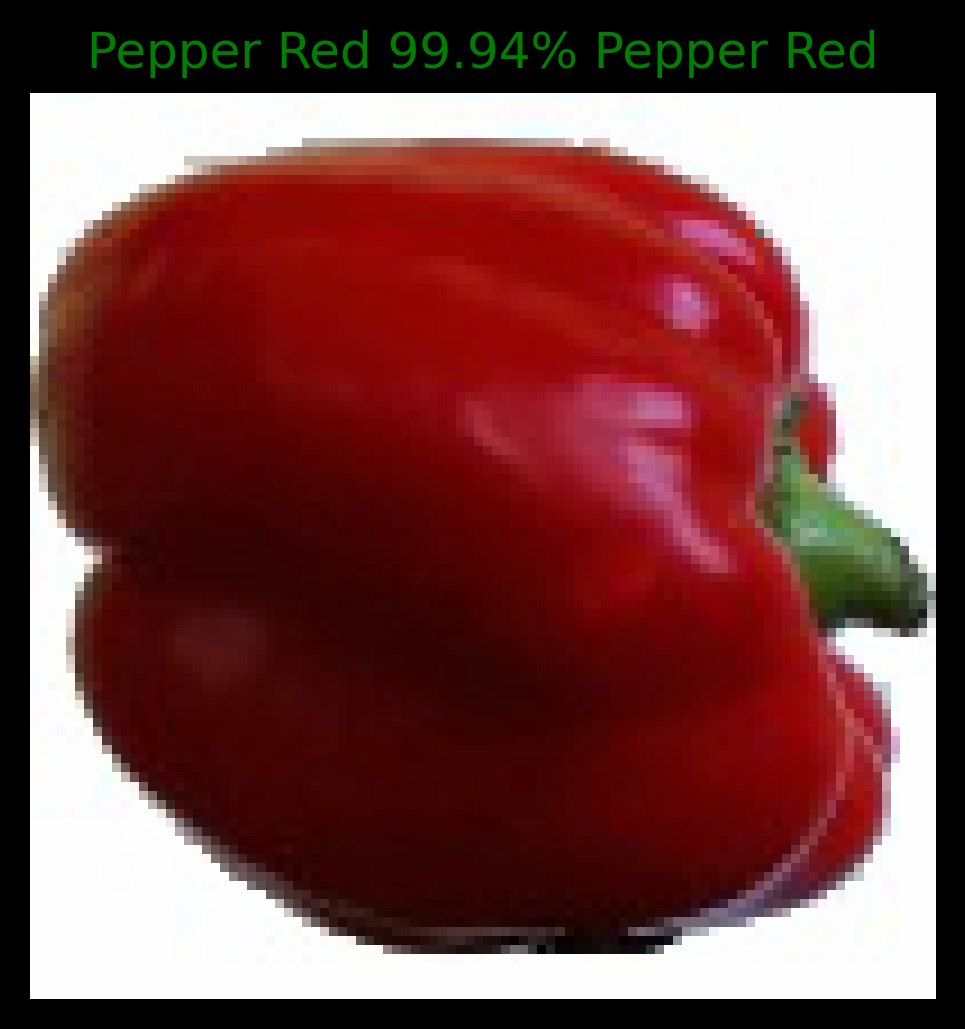

In [35]:
def mpl_imshow(image, one_channel=False):
    image = image.numpy().transpose((1, 2, 0))
    image = image * std + mean
    image = np.clip(image, 0, 1)
    plt.axis('off')
    if one_channel:
        plt.imshow(image[:,:,1], cmap=plt.cm.binary)
    else:
        plt.imshow(image)

def plot_pred(pred_probs, labels, images, n=1, one_channel=False):
    prob = pred_probs[n][0] * 100
    true = idx_class.get(labels[n].item())
    image = images[n] 
    pred = idx_class.get(cat_preds[n][0])

    color = 'green' if pred == true else 'red'

    mpl_imshow(images[n].cpu().detach(), one_channel=one_channel)

    plt.title('{} {:.2f}% {}'.format(pred, prob, true), color=color)
    plt.axis('off');


plot_pred(top_probs, cat_labels, cat_images, n=18)

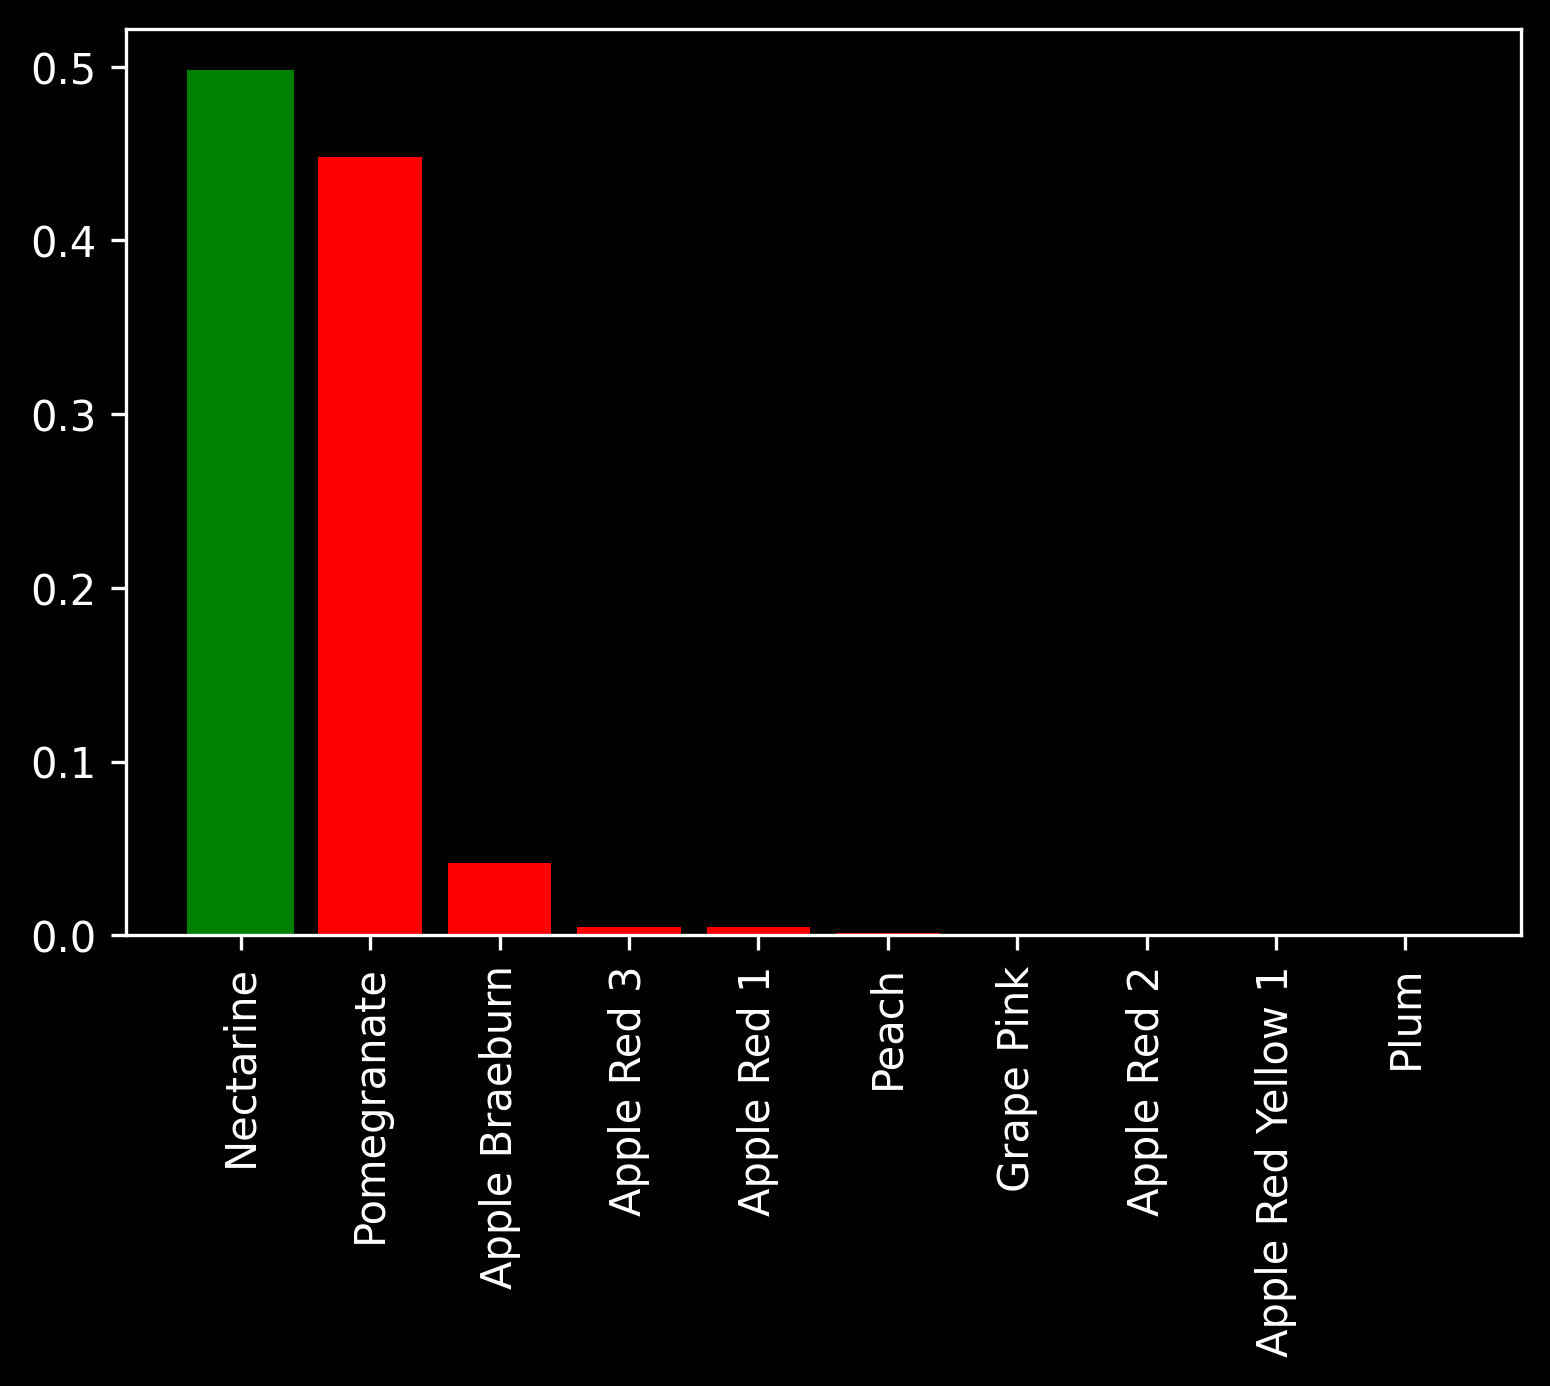

In [25]:
def plot_confidence(pred_probs, labels, n=1):
    preds = [idx_class.get(p) for p in cat_preds[n]]
    probs = pred_probs[n]
    true = idx_class.get(labels[n].item())

    plot = plt.bar(np.arange(len(preds)),
                probs,
                color='red')
    
    plt.xticks(np.arange(len(preds)),
               labels=preds,
               rotation='vertical')
    
    if np.isin(true, preds):
        plot[preds == true].set_color('green')
    else:
        pass

plot_confidence(top_probs, cat_labels, n=17)

## Plotting Bad Predictions

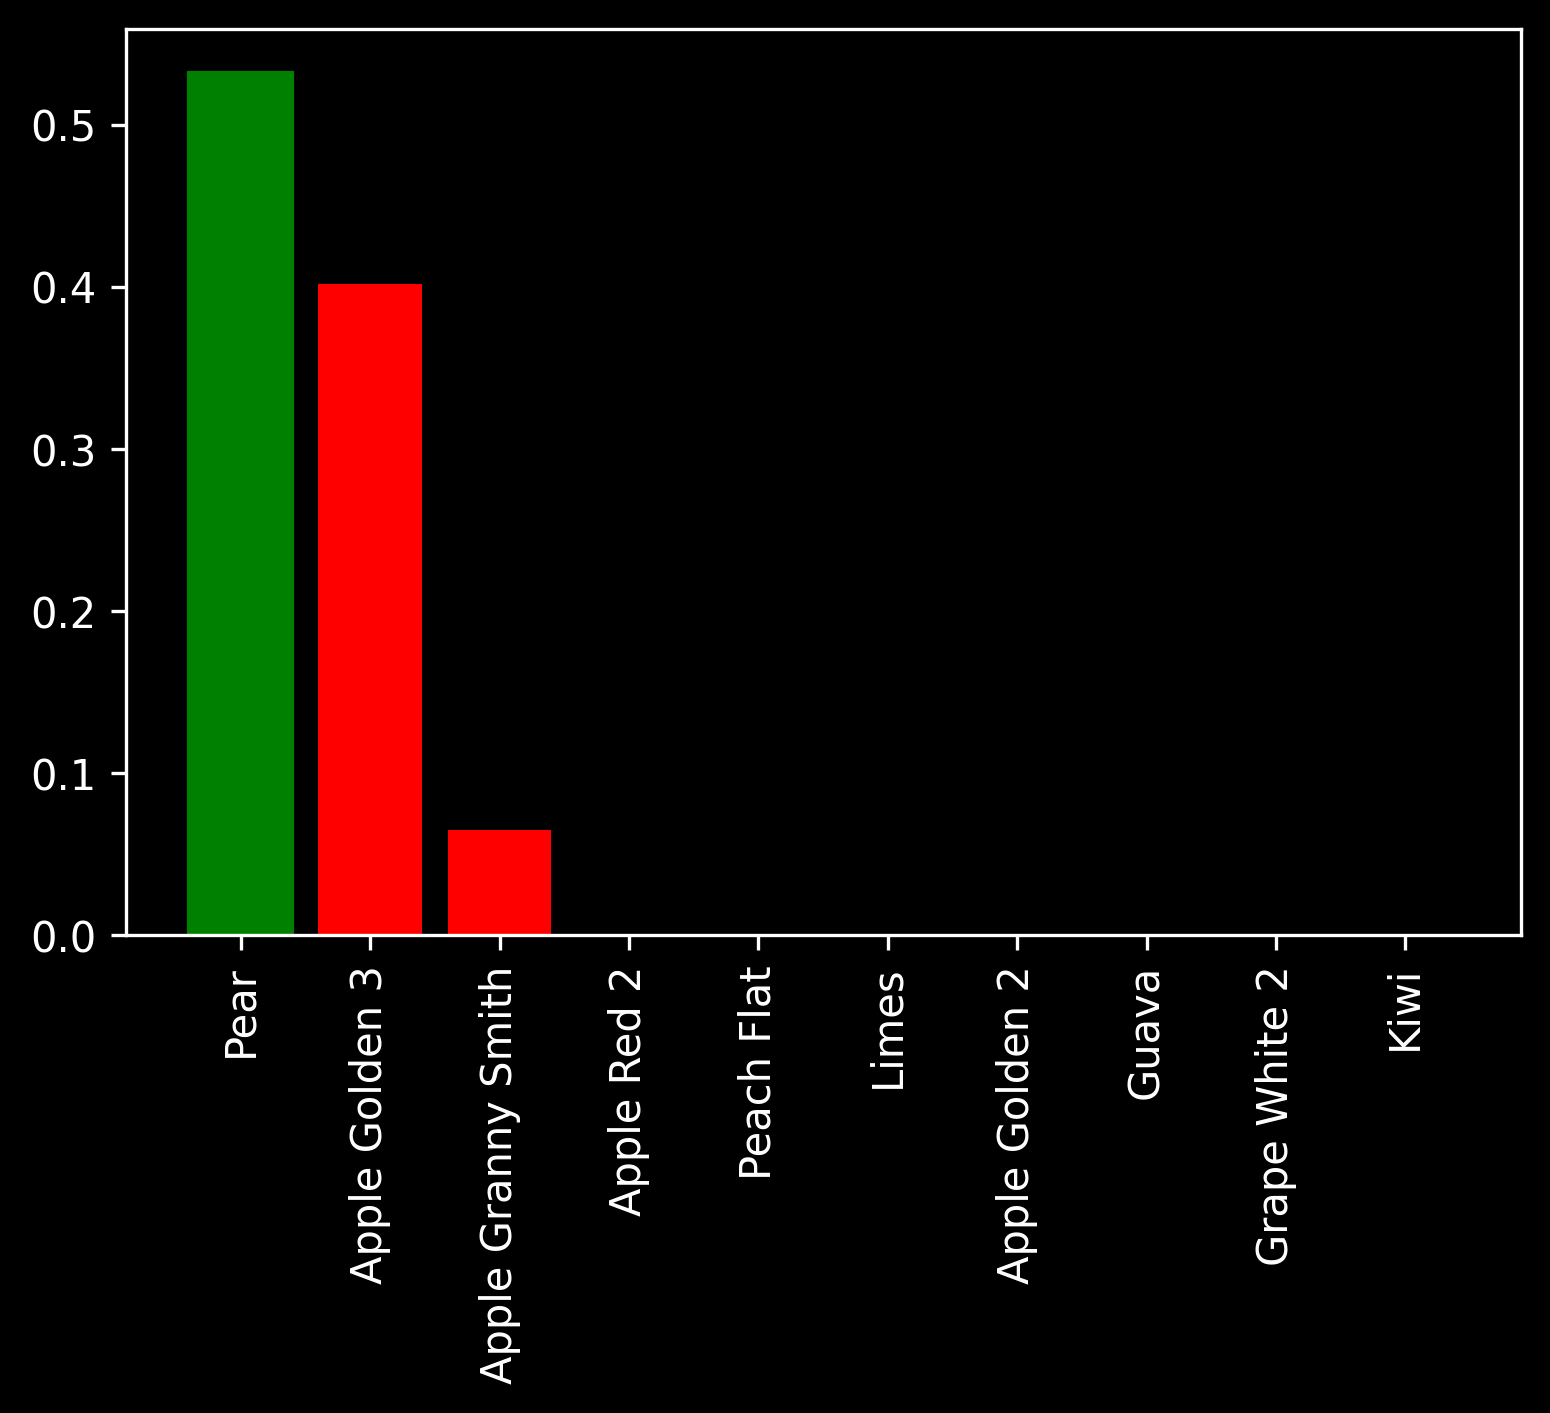

In [34]:
bad_preds = []

for idx, arr in enumerate(top_probs):
    if arr[0] < .70:
        bad_preds.append(idx)

plot_confidence(top_probs, cat_labels, n=bad_preds[1])

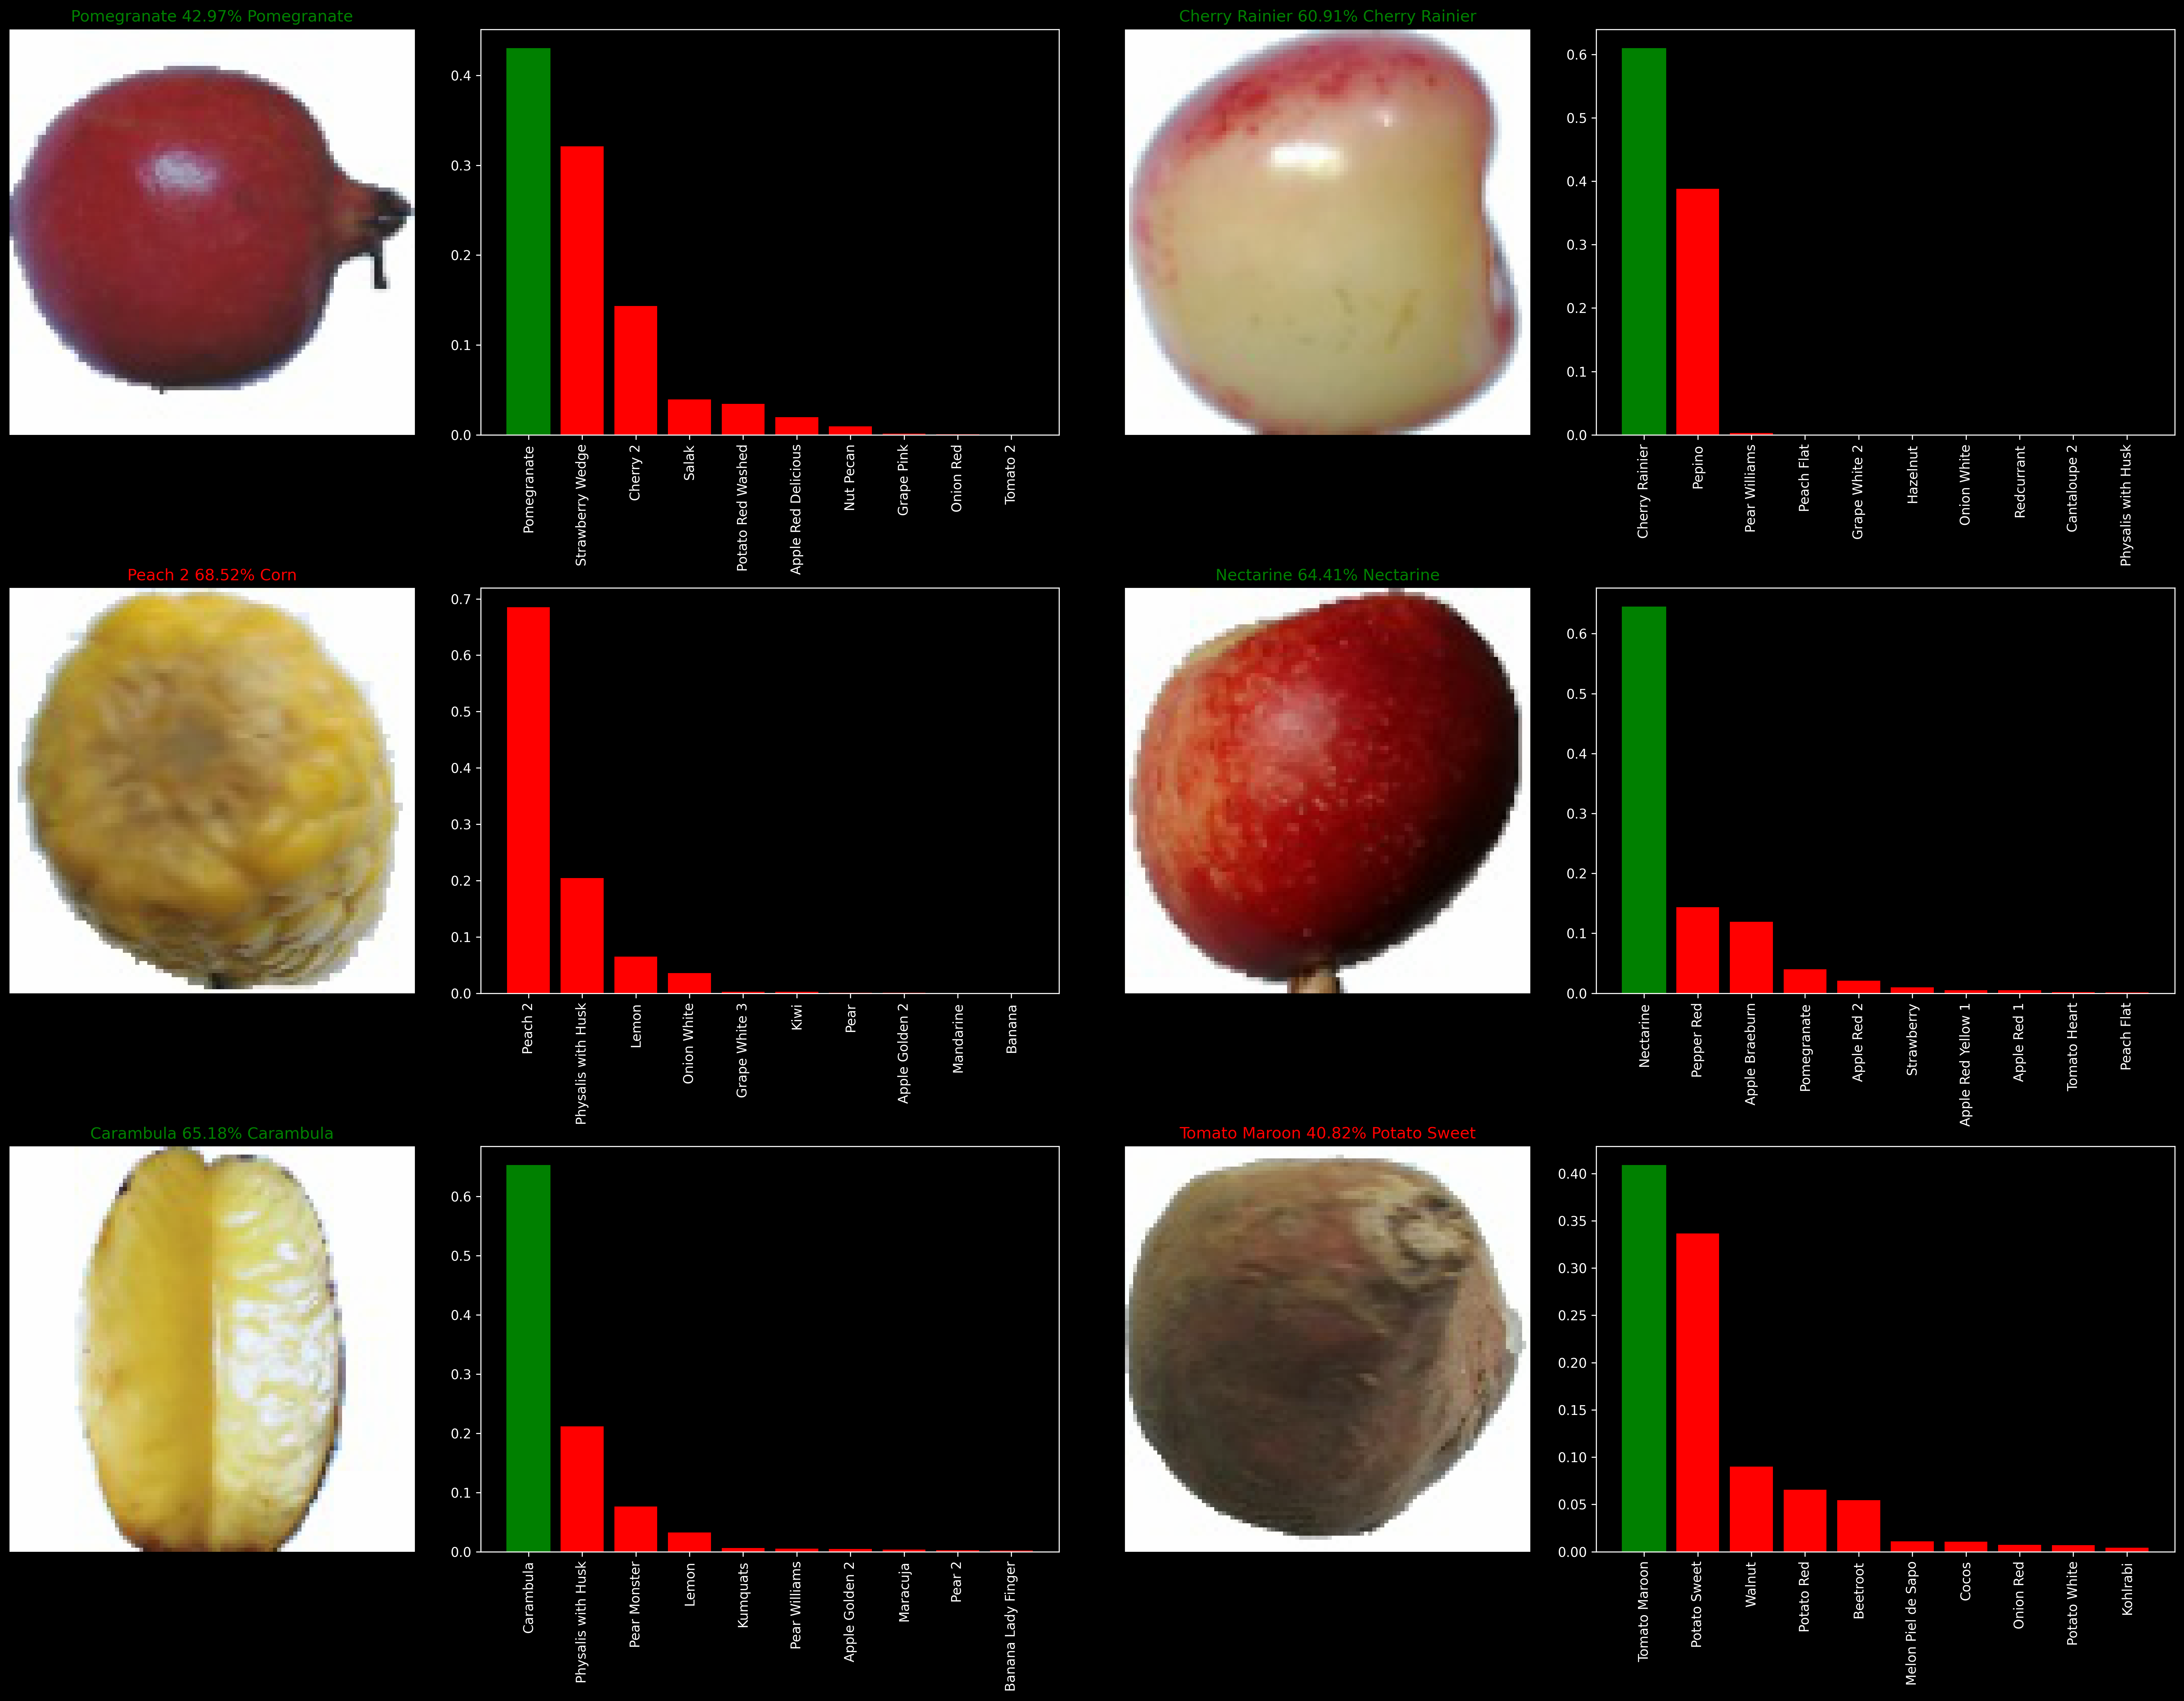

In [27]:
idx_shift = 5
n_rows, n_cols = 3, 2
n_images = n_rows*n_cols
plt.figure(figsize=(6*2*n_cols, 6*n_rows))

for idx in range(n_images):
    plt.subplot(n_rows, 2*n_cols, 2*idx+1)
    plot_pred(top_probs, cat_labels, cat_images, n=bad_preds[idx+idx_shift])

    plt.subplot(n_rows, 2*n_cols, 2*idx+2)
    plot_confidence(top_probs, cat_labels, n=bad_preds[idx+idx_shift])
    
    plt.tight_layout(h_pad=1.0);

## Creating Prediction Probability Dataframe

In [28]:
preds_all = list(list(zip(*cat_preds))[0])

prob_arr = [el.cpu().numpy() for el in cat_probs]
labs = [idx_class.get(i.item()) for i in cat_labels]
preds_ = [idx_class.get(i) for i in preds_all]

prob_df = pd.DataFrame(prob_arr)
prob_df.insert(loc=0, column='true', value=labs)
prob_df.insert(loc=1, column='pred', value=preds_)
prob_df = prob_df.rename(columns=dict(zip(prob_df.columns.values[2:], class_names)))

prob_df.head()

true            pred  ...        Walnut    Watermelon
0        Hazelnut        Hazelnut  ...  3.724758e-10  8.972095e-15
1          Walnut          Walnut  ...  9.994683e-01  2.880806e-10
2            Corn     Onion White  ...  2.661708e-08  4.537020e-08
3  Pomelo Sweetie  Pomelo Sweetie  ...  2.119485e-10  3.355480e-07
4  Apple Golden 2  Apple Golden 2  ...  2.367771e-10  1.438131e-08

[5 rows x 133 columns]

#### To verify that the data is in the correct place

In [29]:
prob_df.select_dtypes(exclude=['O']).idxmax(axis=1)

0              Hazelnut
1                Walnut
2           Onion White
3        Pomelo Sweetie
4        Apple Golden 2
              ...      
22683        Pear Abate
22684    Cherry Rainier
22685          Maracuja
22686     Grape White 4
22687          Cherry 2
Length: 22688, dtype: object

## ROC Curve

In [30]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import matplotlib.colors as mcolors

n_classes = len(class_names)
labels = cat_labels.cpu()
probs = cat_probs.cpu()

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve([1 if lab == i else 0 for lab in labels], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

y_test = np.array([[1 if lab == i else 0 for lab in labels] for i in range(n_classes)]).ravel()
y_preds = probs.numpy().T.ravel()

fpr['micro'], tpr['micro'], _ = roc_curve(y_test, y_preds)
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  


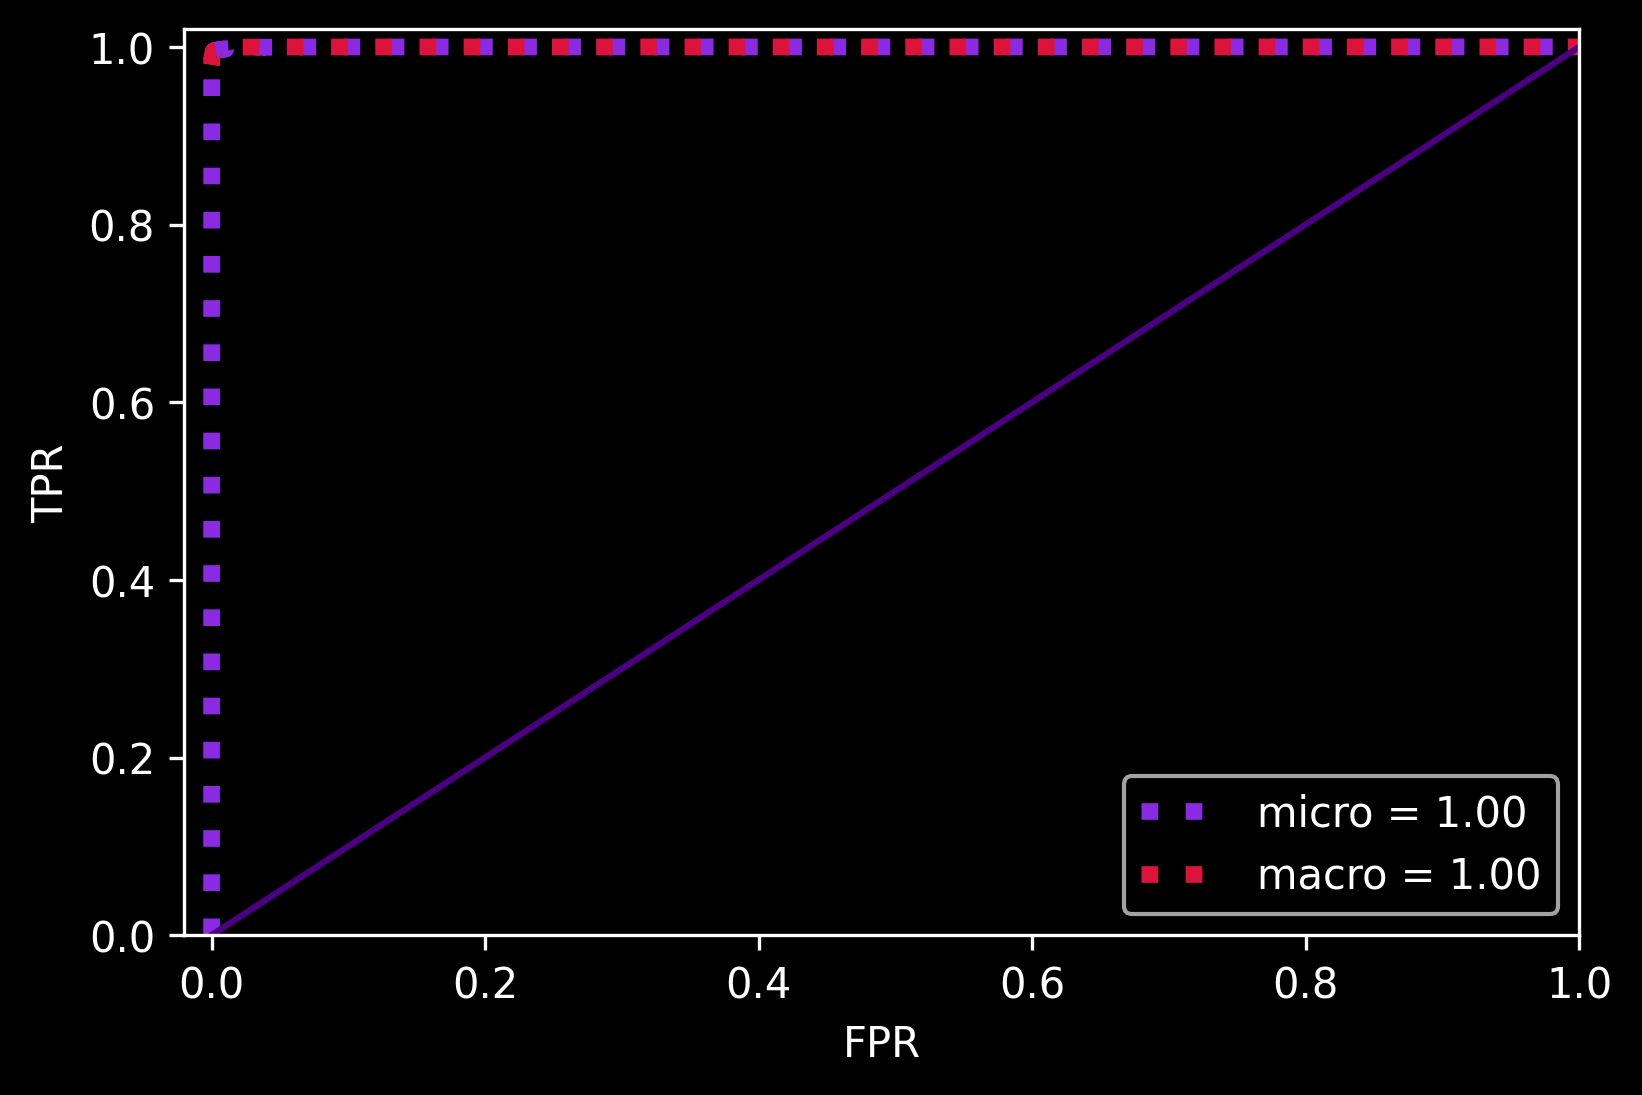

In [31]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

plt.figure()
plt.plot(fpr['micro'], tpr['micro'],
         label='micro = {:.2f}'.format(roc_auc['micro']),
         color='blueviolet', ls='dotted', lw=4)

plt.plot(fpr['macro'], tpr['macro'],
         label='macro = {:.2f}'.format(roc_auc['macro']),
         color='crimson', ls='dotted', lw=4)

plt.plot([0, 1], [0, 1], 'indigo')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=0);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  


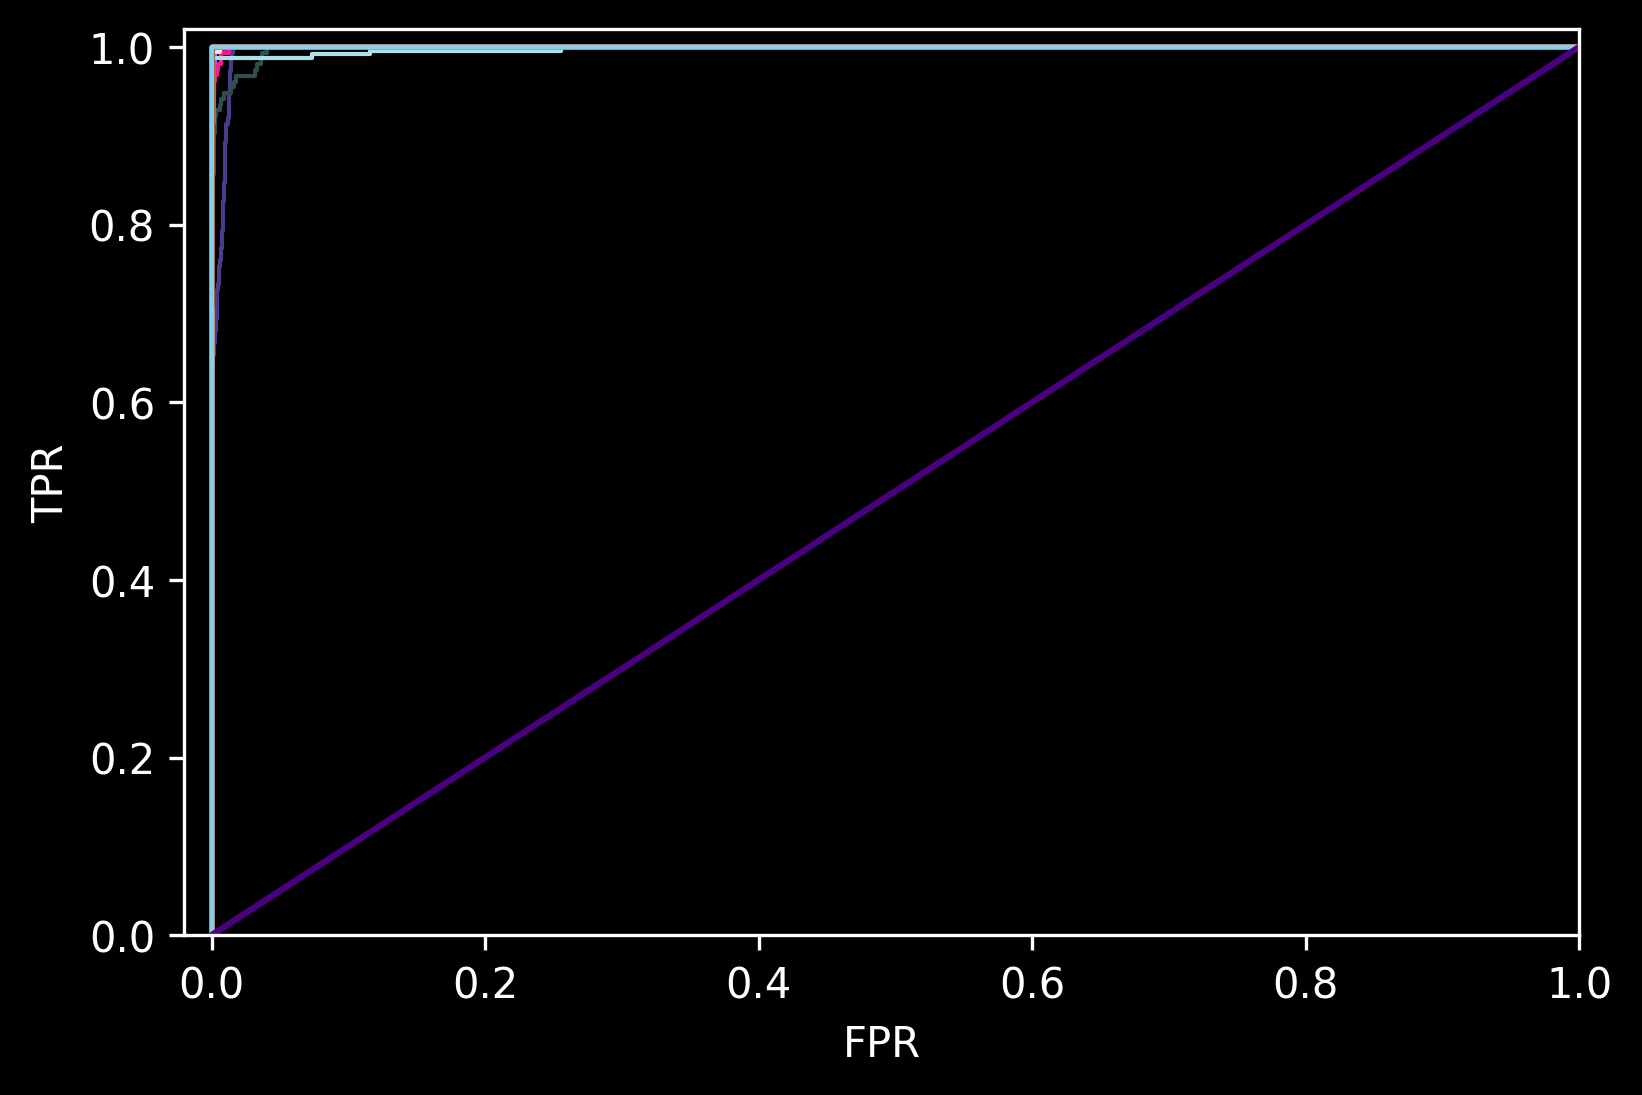

In [32]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

plt.figure()
plt.plot(fpr['micro'], tpr['micro'],
         label='micro = {:.2f}'.format(roc_auc['micro']),
         color='blueviolet', ls='--', lw=1)

plt.plot(fpr['macro'], tpr['macro'],
         label='macro = {:.2f}'.format(roc_auc['macro']),
         color='crimson', ls='--', lw=1)

a = list(mcolors.CSS4_COLORS.keys())

colors = cycle(a)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'indigo')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('FPR')
plt.ylabel('TPR');